# CFO Correction Network

This notebooks contains two network architectures to **learn to correct Carrier Frequency Offset (CFO)**, given preamble and preamble convolved data.

* **First Approach**: Feedforward network (~36K trainable paramters)
    * Pros: Faster inference
    * Cons: Fixed Preabmle Length
* **Second Approach**: Recurrent Neural Network network (~10K trainable paramters)
    * Pros: variable preamble length
    * Cons: Slower
    
## Environment Setup

### Required packages
* Tensorflow
* Keras
* Commpy
* Pydot
*  `graphviz` for visualization. `sudo apt-get install graphviz`

In [1]:
# Import packages from other direction. Itis necessary if the project is structured as:
# my_project
# ├── notebooks
# │   └── current_notebook.ipynb
# ├── local_python_package
# │   ├── __init__.py
# │   ├── models.py
# ├── README.md
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import multiprocessing as mp
import numpy as np
import tensorflow as tf
from radioml.dataset import RadioDataGenerator
from sklearn.metrics import mean_squared_error

# For visualization
from IPython.display import SVG, display
from keras.utils.vis_utils import model_to_dot
import matplotlib.pyplot as plt
import seaborn as sns
import pylab

Using TensorFlow backend.


## Define Parameters for this experiment

In [3]:
DATA_LEN = 200
PREAMBLE_LEN = 40
CHANNEL_LEN = 1

SNR_TRAIN = 20.0
OMEGA_TRAIN = 1/50

## Define Data Generators for both two approaches

In [4]:
# Define Radio
radio = RadioDataGenerator(DATA_LEN,PREAMBLE_LEN, CHANNEL_LEN, modulation_scheme='QPSK')

training_generator   = radio.cfo_data_generator(OMEGA_TRAIN, SNR_TRAIN, 
                                                batch_size=256, num_cpus=16)

validation_generator = radio.cfo_data_generator(OMEGA_TRAIN, SNR_TRAIN, 
                                                batch_size=256, num_cpus=16, seed=2018)

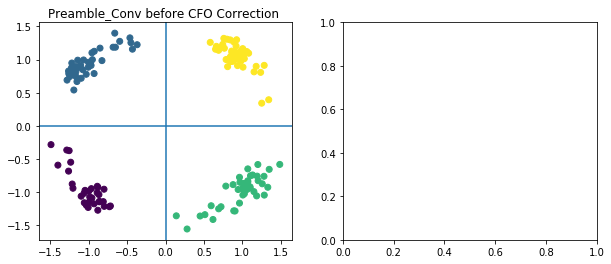

In [5]:
# Visualize a few examples
examples = next(radio.cfo_data_generator(OMEGA_TRAIN, SNR_TRAIN, batch_size=4, num_cpus=8))
[preambles, preambles_conv], cfo_corrected = examples
symbols, groundtruths = np.unique(preambles.view(np.complex),return_inverse=True)

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ax1.scatter(preambles_conv[...,0].flatten(),
            preambles_conv[...,1].flatten(), c=groundtruths)
ax1.axhline()
ax1.axvline()

_ = ax1.set_title("Preamble_Conv before CFO Correction ")


## First Approach: Feedforward Network

Number of training parameters: 36401


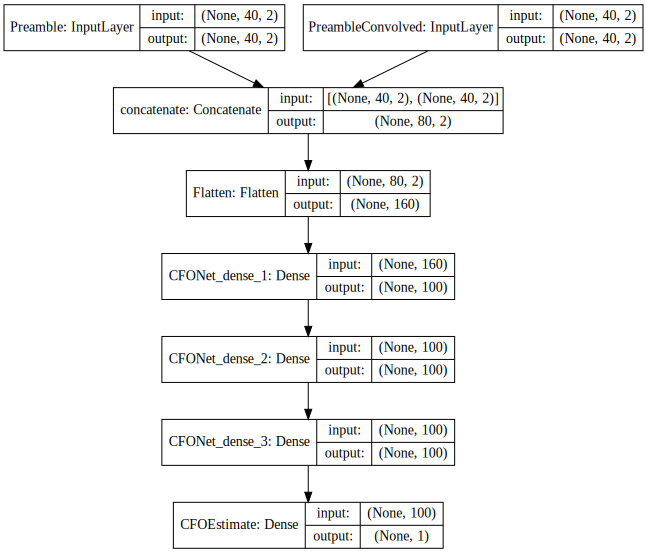

In [6]:
tf.keras.backend.clear_session()

def cfo_network(preamble, preamble_conv, scope='CFONet'):
    """
    Arguments:
        preamble :     tf.Tensor float32 -  [batch, preamble_length, 2]
        preamble_conv: tf.Tensor float32 -  [batch, preamble_length, 2]
        
    Return:
        cfo_estimate: tf.Tensor float32 - [batch_size, 1]
    """
    with tf.name_scope(scope):
        inputs = tf.keras.layers.concatenate([preamble, preamble_conv], axis=1)
        inputs = tf.keras.layers.Flatten(name='Flatten')(inputs)
        x = tf.keras.layers.Dense(100, 'tanh', name=scope+"_dense_1")(inputs)
        x = tf.keras.layers.Dense(100, 'tanh', name=scope+"_dense_2")(x)
        x = tf.keras.layers.Dense(100, 'tanh', name=scope+"_dense_3")(x)
    cfo_est = tf.keras.layers.Dense(1, 'linear',name='CFOEstimate')(x)
    
    return cfo_est

# ############################
# Construct FeedForward Model
# ############################
# Think of keras.Input as tf.placeholder
preamble       = tf.keras.layers.Input(shape=(40, 2), name='Preamble')
preamble_conv  = tf.keras.layers.Input(shape=(40, 2), name='PreambleConvolved')

# Build tensorflow graph
omega_estimate  = cfo_network(preamble, preamble_conv)

# Instead of using TF training API, we convert Graph to tf.keras.Model.
model = tf.keras.Model(inputs=[preamble, preamble_conv],
                       outputs=omega_estimate)

print("Number of training parameters: %d" % model.count_params())
tf.keras.utils.plot_model(model, "model.svg", show_shapes=True, show_layer_names=True)
SVG("model.svg")

In [ ]:
model.compile('adam','mse')
history = model.fit_generator(
    generator=training_generator,
    validation_data=validation_generator,
    steps_per_epoch=1000,
    validation_steps=100,
    callbacks=[tf.keras.callbacks.ModelCheckpoint('../models/cfo_nn_tanh_omgega.hdf5', save_best_only=True)],
    epochs=10)

Epoch 1/50
1000/1000 [==============================] - 166s 166ms/step - loss: 0.0027 - val_loss: 3.0882e-04
Epoch 2/50
1000/1000 [==============================] - 164s 164ms/step - loss: 2.3164e-04 - val_loss: 1.8926e-04
Epoch 3/50
1000/1000 [==============================] - 169s 169ms/step - loss: 1.4517e-04 - val_loss: 1.1884e-04
Epoch 4/50
1000/1000 [==============================] - 168s 168ms/step - loss: 7.9307e-05 - val_loss: 7.7286e-05
Epoch 5/50
1000/1000 [==============================] - 164s 164ms/step - loss: 5.1112e-05 - val_loss: 5.4337e-05
Epoch 6/50
1000/1000 [==============================] - 164s 164ms/step - loss: 3.5172e-05 - val_loss: 3.5468e-05
Epoch 7/50
1000/1000 [==============================] - 164s 164ms/step - loss: 2.4023e-05 - val_loss: 1.9056e-05
Epoch 8/50
1000/1000 [==============================] - 165s 165ms/step - loss: 1.5570e-05 - val_loss: 1.2388e-05
Epoch 9/50
1000/1000 [==============================] - 164s 164ms/step - loss: 1.1160e-05 -

Process ForkPoolWorker-30:
Process ForkPoolWorker-32:
Process ForkPoolWorker-12:
Process ForkPoolWorker-31:
Process ForkPoolWorker-18:
Process ForkPoolWorker-11:
Process ForkPoolWorker-20:
Process ForkPoolWorker-24:
Process ForkPoolWorker-34:
Process ForkPoolWorker-29:
Process ForkPoolWorker-26:
Process ForkPoolWorker-35:
Process ForkPoolWorker-23:
Process ForkPoolWorker-27:
Process ForkPoolWorker-15:
Traceback (most recent call last):
Process ForkPoolWorker-21:
Process ForkPoolWorker-37:
Process ForkPoolWorker-28:
Process ForkPoolWorker-16:
Process ForkPoolWorker-17:
Process ForkPoolWorker-38:
Process ForkPoolWorker-33:
Process ForkPoolWorker-36:
Traceback (most recent call last):
Process ForkPoolWorker-9:
Process ForkPoolWorker-14:
Process ForkPoolWorker-25:
Traceback (most recent call last):
Process ForkPoolWorker-19:
Process ForkPoolWorker-13:
Process ForkPoolWorker-40:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Tracebac

  File "/home/dat/miniconda2/envs/deepcom/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/dat/miniconda2/envs/deepcom/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/home/dat/miniconda2/envs/deepcom/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/dat/miniconda2/envs/deepcom/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "/home/dat/miniconda2/envs/deepcom/lib/python3.6/multiprocessing/pool.py", line 125, in worker
    put((job, i, result))
  File "/home/dat/miniconda2/envs/deepcom/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/dat/miniconda2/envs/deepcom/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/dat/miniconda2/envs/deepcom/lib/python3.6/multiprocess

  File "/home/dat/miniconda2/envs/deepcom/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
  File "/home/dat/miniconda2/envs/deepcom/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/home/dat/miniconda2/envs/deepcom/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/home/dat/miniconda2/envs/deepcom/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/dat/miniconda2/envs/deepcom/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/dat/miniconda2/envs/deepcom/lib/python3.6/multiprocessing/pool.py", line 44, in mapstar
    return list(map(*args))
  File "/home/dat/miniconda2/envs/deepcom/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/home/dat/miniconda2/envs/deepcom

KeyboardInterrupt
KeyboardInterrupt
  File "/home/dat/miniconda2/envs/deepcom/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/home/dat/miniconda2/envs/deepcom/lib/python3.6/site-packages/numpy/lib/function_base.py", line 2755, in __call__
    return self._vectorize_call(func=func, args=vargs)
KeyboardInterrupt
  File "/home/dat/miniconda2/envs/deepcom/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/home/dat/miniconda2/envs/deepcom/lib/python3.6/site-packages/numpy/lib/function_base.py", line 2831, in _vectorize_call
    outputs = ufunc(*inputs)
  File "/home/dat/miniconda2/envs/deepcom/lib/python3.6/site-packages/scikit_commpy-0.3.0-py3.6.egg/commpy/modulation.py", line 44, in <lambda>
    self.constellation[bitarray2dec(input_bits[i:i+self.num_bits_symbol])])
KeyboardInterrupt
  File "/home/dat/miniconda2/envs/deepcom/lib/python3.6/site-packages/scikit_commpy-0.3.

In [ ]:
# Source: https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.grid()
plt.semilogy()
plt.show()

## Evaluate models on different Omegas and SNRs

In [ ]:
# Load best trained models
feedforward = tf.keras.models.load_model('../models/cfo_nn_tanh_omgega.hdf5')

logs = {}
for w in [1/20, 1/50, 1/100]:
    logs[w] = []
    print('[Omega]: %f' % w)
    for snr in [10.0, 15.0, 20.0, 25.0]:
        # Define testing data
        testing_generator = radio.cfo_data_generator(w, snr, batch_size=2000, seed=1111)
        test_inputs, test_labels = next(testing_generator)
        
        # Make Predictions
        nn_predictions  = feedforward.predict(test_inputs)
        
        # Compute MSE
        nn_mse = mean_squared_error(test_labels, nn_predictions)
        
        print('\t[SNR]: %.2f || Feedforward MSE: %.8f' % (snr, nn_mse))
        logs[w].append([nn_mse, rnn_mse])

In [ ]:
k= np.random.randint(0, len(test_labels) - 5)
print('K=%d'%k)
print("True CFO Rate:         ", test_labels[k:k+4])
print("RNN Estimate CFO Rate: ", rnn_predictions[k:k+4].T)
print("NN  Estimate CFO Rate: ", nn_predictions[k:k+4].T)

## Evaluate on longer preamble

In [ ]:
radio = RadioData(data_len    =DATA_LEN, 
                  preamble_len=2*PREAMBLE_LEN,  # 80
                  channels_len=CHANNEL_LEN,
                  modulation_scheme='QPSK')
logs = {}
for w in [1/20, 1/50, 1/100]:
    logs[w] = []
    print('[Omega]: %f' % w)
    for snr in [10.0, 15.0, 20.0, 25.0]:
        # Define testing data
        testing_generator = radio.cfo_correction_data_gen(w, snr, batch_size=2000, seed=1111)
        test_inputs, test_labels = next(testing_generator)
        
        # Make Predictions
        rnn_predictions = recurrent_nn.predict(test_inputs)
        
        # Compute MSE
        rnn_mse =mean_squared_error(test_labels, rnn_predictions)
        
        print('\t[SNR]: %.2f  RecurrentNN MSE: %.8f'% (snr, rnn_mse))
        logs[w].append([nn_mse, rnn_mse])